## Library

In [150]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [151]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Peter'                             # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
initial_gdp = 21 * trillion                       # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Ajeya':
    CREDIBLE_INTERVAL = 0.9                        # These are 90% CIs
    tai_flop_size = lognorm(27.58, 46.29)          # 90% CI, it takes 10^FLOPs to run a transformative AI at inference. Take 10^13-17 from Carlsmith report and add 1 OOM due to algorithmic inefficiency.
                                                   # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day, or a total of about 10^20 operations
    algo_doubling_rate = norm(2.5, 2.5)            # 90% CI, algorithms get twice as efficient every X years
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17.2, 17.2)    # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = norm(2.6, 3)              # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?
    base_p_recursive = 0                           # TODO: explain
    recursive_curve_steepness = 0
    recursive_curve_inflection = 0
    p_recursive_creates_tai_instantly = 0
    recursive_flops_halving_rate_ = None
    recursive_algo_doubling_rate_ = None
    recursive_spend_doubling_time = None
    recursive_gdp_growth_ = None
    recursive_initial_chance_of_nonscaling_issue = None
    recursive_final_chance_of_nonscaling_issue = None

elif USE_NUMBERS == 'Peter':
    CREDIBLE_INTERVAL = 0.9
    tai_flop_size = lognorm(26, 46)
    algo_doubling_rate = norm_lclip(1, 5)
    min_reduction = norm(1, 3)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(4, 8)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17, 17.5)      # More increase in compute, plus possibilities that big companies have found some additional initial efficiency.
    flops_halving_rate = norm(2, 4)
    max_flops_per_dollar = norm(24, 26)            # Added uncertainty around fundamental limits
    initial_pay = norm(7, 8)                       # Minimum of $10M since that has already happened. Uncertain of how much we could be paying privately.
    gdp_growth = lognorm(1.02, 1.04)               # Added uncertainty around potential GDP slowdown
    max_gdp_frac = lognorm_lclip(0.0015, 0.025)    # Added uncertainty around how much of GDP we'd be willing to spend
    willingness_ramp = norm(0.7, 1)
    spend_doubling_time = lognorm_lclip(0.5, 2)    # Added uncertainty around how fast spending will accelerate
    initial_chance_of_nonscaling_issue = 0.75
    final_chance_of_nonscaling_issue = 0.1
    nonscaling_issue_bottom_year = 2040
    nonscaling_delay = lognorm(1, 20)
    base_p_recursive = 0.5
    recursive_curve_steepness = 35
    recursive_curve_inflection = 0.1
    p_recursive_creates_tai_instantly = 0.05
    recursive_flops_halving_rate = lognorm_lclip(0.3, 2)
    recursive_algo_doubling_rate = lognorm_lclip(0.3, 2)
    recursive_spend_doubling_time = lognorm_lclip(0.3, 2)
    recursive_gdp_growth = lognorm_lclip(1.02, 1.1)
    recursive_initial_chance_of_nonscaling_issue = 0.2
    recursive_final_chance_of_nonscaling_issue = 0.01
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 709:
        return 10 ** (math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    else:
        ratio = flops_we_have / flops_needed_for_tai
        return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


In [152]:
initial_flops_p = get_percentiles([sample(tai_flop_size, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
initial_flops_p

{95: 25.979758549690718,
 90: 27.30772696618838,
 80: 29.544436371066823,
 70: 31.10681280196077,
 60: 32.72169535047754,
 50: 34.28880384885302,
 40: 35.81225508117242,
 30: 37.5297330675776,
 20: 39.37378576500593,
 10: 42.78174281839348,
 5: 46.013712928357684}

In [153]:
min_reduction_p = get_percentiles([sample(min_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
min_reduction_p

{95: 1.001352607652853,
 90: 1.2433626452170687,
 80: 1.5177231379165312,
 70: 1.702034688422358,
 60: 1.8492958337543068,
 50: 1.9955447243483122,
 40: 2.145189343008327,
 30: 2.326063199743135,
 20: 2.5002304185390236,
 10: 2.7428139874938036,
 5: 2.9776558191407028}

In [154]:
max_reduction_p = get_percentiles([sample(max_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
max_reduction_p

{95: 3.928095961048404,
 90: 4.412322802795106,
 80: 4.944124117116677,
 70: 5.323263056188263,
 60: 5.66097720276003,
 50: 5.95161795888454,
 40: 6.245187120747344,
 30: 6.592157743122599,
 20: 6.988429850230332,
 10: 7.560618723936494,
 5: 8.074342483087744}

In [155]:
algo_doubling_rate_p = get_percentiles([sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
algo_doubling_rate_p

{95: 1.0633330857185845,
 90: 1.4727335111221607,
 80: 1.957042401519583,
 70: 2.3507272836980384,
 60: 2.7399014505476442,
 50: 2.986738410288095,
 40: 3.311885162655008,
 30: 3.637135662833181,
 20: 4.028702459607217,
 10: 4.499946268656105,
 5: 4.875015327177461}

In [156]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_flops_per_dollar_p

{5: 17.01404376847517,
 10: 17.064459970140383,
 20: 17.127291196519483,
 30: 17.17878576144399,
 40: 17.222848688864417,
 50: 17.253592114745338,
 60: 17.28345273913076,
 70: 17.32661919555614,
 80: 17.380720963424213,
 90: 17.45086430196891,
 95: 17.497645857429145}

In [157]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
flops_halving_rate_p

{95: 1.9708728549288639,
 90: 2.195198452971683,
 80: 2.4660114092813767,
 70: 2.7046889486208627,
 60: 2.8628955975039867,
 50: 3.010849434511641,
 40: 3.1519096140348877,
 30: 3.3058710089893886,
 20: 3.4770294426682815,
 10: 3.73611550773104,
 5: 3.9306612261208573}

In [158]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_flops_per_dollar_p

{5: 24.008514592804765,
 10: 24.199107345024732,
 20: 24.49895391847129,
 30: 24.68331077162835,
 40: 24.861844334877347,
 50: 25.016219909822865,
 60: 25.163484955083874,
 70: 25.324962703357546,
 80: 25.519486516037766,
 90: 25.746639338319856,
 95: 26.011081758375436}

In [159]:
initial_pay_p = get_percentiles([sample(initial_pay, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_pay_p

{5: 6.994288071730866,
 10: 7.093510972305692,
 20: 7.235607852439848,
 30: 7.3444079716245945,
 40: 7.42981409686605,
 50: 7.503127616570344,
 60: 7.5743408316053795,
 70: 7.65357466390809,
 80: 7.75007923741503,
 90: 7.891598383283101,
 95: 8.010435281575734}

In [160]:
gdp_growth_p = get_percentiles([sample(gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
gdp_growth_p

{5: 1.0201587864054356,
 10: 1.0221245806371422,
 20: 1.024699064240275,
 30: 1.0264297032763277,
 40: 1.028153682957099,
 50: 1.0297634149898518,
 60: 1.031286311464679,
 70: 1.0329830729144185,
 80: 1.0352908112472459,
 90: 1.0378315440179042,
 95: 1.039827986184736}

In [161]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_gdp_frac_p

{5: 0.0015124219542379301,
 10: 0.0021338144506687666,
 20: 0.0030368423516880655,
 30: 0.003807684665822604,
 40: 0.004980547408190242,
 50: 0.006067588329930275,
 60: 0.007508872656494758,
 70: 0.009536692827512638,
 80: 0.012322297727904545,
 90: 0.017957776975443256,
 95: 0.02376840423968525}

In [162]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
willingness_ramp_p

{5: 0.7069652088232237,
 10: 0.7316989852399404,
 20: 0.7685391727161072,
 30: 0.7992349325121857,
 40: 0.8241376009317429,
 50: 0.8491636424234215,
 60: 0.8742083464136092,
 70: 0.9004365356896071,
 80: 0.9291321764097489,
 90: 0.9687593802328318,
 95: 1.0058503901670346}

In [163]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
spend_doubling_time_p

{95: 0.5074052513747148,
 90: 0.5900572060656288,
 80: 0.6996206137607374,
 70: 0.8055094332820064,
 60: 0.8932926886952475,
 50: 0.997309259523124,
 40: 1.11097889216683,
 30: 1.2439700576411732,
 20: 1.4235214109099448,
 10: 1.6918103566959193,
 5: 2.018217738577467}

In [164]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
nonscaling_delay_p

{95: 0.9202424481378373,
 90: 1.3100891933249041,
 80: 1.9708601309655847,
 70: 2.7785914854735596,
 60: 3.7227539869140505,
 50: 4.626340002447273,
 40: 5.93516886071834,
 30: 7.500960948568233,
 20: 10.171084079388686,
 10: 14.375767411208441,
 5: 19.799786502255294}

In [165]:
if recursive_flops_halving_rate:
    recursive_flops_halving_rate_ = get_percentiles([sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_flops_halving_rate_)
else:
    print('N/A')


{5: 0.3294175790697059, 10: 0.38425868107820205, 20: 0.4761995996376717, 30: 0.5720414674285985, 40: 0.6675424688906868, 50: 0.7661042070311694, 60: 0.8966059171126832, 70: 1.0377608731645196, 80: 1.2335065093512245, 90: 1.5735179422342718, 95: 1.9187294239507011}


In [166]:
if recursive_algo_doubling_rate:
    recursive_algo_doubling_rate_ = get_percentiles([sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_algo_doubling_rate_)
else:
    print('N/A')
    

{5: 0.3213785674651618, 10: 0.3863753492328773, 20: 0.49442990729535247, 30: 0.5945186933617667, 40: 0.6918073393073859, 50: 0.7846191194835787, 60: 0.9036452090528242, 70: 1.0497317435642528, 80: 1.2633559936676635, 90: 1.5915769651530425, 95: 1.9525163532468255}


In [167]:
if recursive_spend_doubling_time:
    recursive_spend_doubling_time_ = get_percentiles([sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_spend_doubling_time_)
else:
    print('N/A')


{5: 0.3, 10: 0.3790441919300136, 20: 0.4922558613297798, 30: 0.5902368506664156, 40: 0.6866382904079724, 50: 0.7749188510494447, 60: 0.876985783342676, 70: 1.040291585612092, 80: 1.2160181193890662, 90: 1.5931870246536672, 95: 1.9167118644100518}


In [168]:
if recursive_gdp_growth:
    recursive_gdp_growth_ = get_percentiles([sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_gdp_growth_)
else:
    print('N/A')
    

{5: 1.0219666290384326, 10: 1.0298136393492012, 20: 1.0400123853076415, 30: 1.0468560368965878, 40: 1.0523831022472079, 50: 1.0588109598300774, 60: 1.0657841881372057, 70: 1.0709443363297657, 80: 1.0783554069829153, 90: 1.089348893431856, 95: 1.0989529484015779}


## GDP Over Time

Text(0, 0.5, 'log GDP')

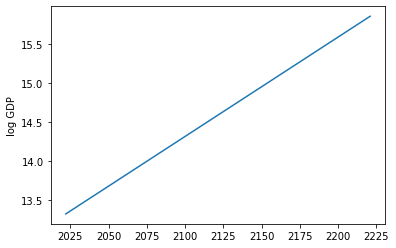

In [169]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [170]:
for y in years:
    print('Year: {} - GDP log$ {} ({})'.format(y,
                                               np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                               numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log$ 13.3 (10 trillion)
Year: 2023 - GDP log$ 13.3 (10 trillion)
Year: 2024 - GDP log$ 13.3 (10 trillion)
Year: 2025 - GDP log$ 13.4 (10 trillion)
Year: 2026 - GDP log$ 13.4 (10 trillion)
Year: 2027 - GDP log$ 13.4 (10 trillion)
Year: 2028 - GDP log$ 13.4 (10 trillion)
Year: 2029 - GDP log$ 13.4 (10 trillion)
Year: 2030 - GDP log$ 13.4 (10 trillion)
Year: 2031 - GDP log$ 13.4 (10 trillion)
Year: 2032 - GDP log$ 13.4 (10 trillion)
Year: 2033 - GDP log$ 13.5 (10 trillion)
Year: 2034 - GDP log$ 13.5 (10 trillion)
Year: 2035 - GDP log$ 13.5 (10 trillion)
Year: 2036 - GDP log$ 13.5 (10 trillion)
Year: 2037 - GDP log$ 13.5 (10 trillion)
Year: 2038 - GDP log$ 13.5 (10 trillion)
Year: 2039 - GDP log$ 13.5 (10 trillion)
Year: 2040 - GDP log$ 13.6 (10 trillion)
Year: 2041 - GDP log$ 13.6 (10 trillion)
Year: 2042 - GDP log$ 13.6 (10 trillion)
Year: 2043 - GDP log$ 13.6 (10 trillion)
Year: 2044 - GDP log$ 13.6 (10 trillion)
Year: 2045 - GDP log$ 13.6 (10 trillion)
Year: 2046 - GDP

## Willingness to Pay Over Time

Text(0, 0.5, 'log $ willing to spend on TAI')

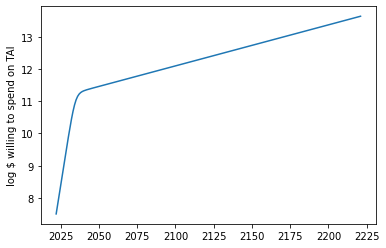

In [171]:
willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                           gdp_growth=gdp_growth_p[GRAPH_P],
                                           initial_pay=10 ** initial_pay_p[GRAPH_P],
                                           spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                           max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                           year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(willingness))
plt.ylabel('log $ willing to spend on TAI')


In [172]:
for y in years:
    print('Year: {} - willingness log$ {} ({})'.format(y,
                                                       np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(willingness[y - CURRENT_YEAR]))))

Year: 2022 - willingness log$ 7.5 (10 million)
Year: 2023 - willingness log$ 7.8 (10 million)
Year: 2024 - willingness log$ 8.1 (100 million)
Year: 2025 - willingness log$ 8.4 (100 million)
Year: 2026 - willingness log$ 8.7 (100 million)
Year: 2027 - willingness log$ 9.0 (one billion)
Year: 2028 - willingness log$ 9.3 (one billion)
Year: 2029 - willingness log$ 9.6 (one billion)
Year: 2030 - willingness log$ 9.9 (one billion)
Year: 2031 - willingness log$ 10.2 (10 billion)
Year: 2032 - willingness log$ 10.4 (10 billion)
Year: 2033 - willingness log$ 10.7 (10 billion)
Year: 2034 - willingness log$ 10.9 (10 billion)
Year: 2035 - willingness log$ 11.0 (100 billion)
Year: 2036 - willingness log$ 11.2 (100 billion)
Year: 2037 - willingness log$ 11.2 (100 billion)
Year: 2038 - willingness log$ 11.3 (100 billion)
Year: 2039 - willingness log$ 11.3 (100 billion)
Year: 2040 - willingness log$ 11.3 (100 billion)
Year: 2041 - willingness log$ 11.3 (100 billion)
Year: 2042 - willingness log$ 11.4 

## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

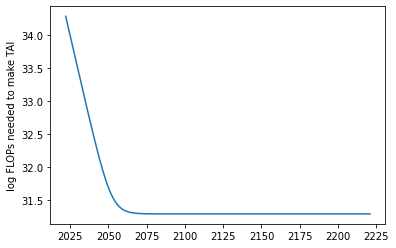

In [173]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [174]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} ({})'.format(y,
                                                               np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                               numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.3 (10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.2 (10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.1 (10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.0 (one decillion)
Year: 2026 - log FLOPs needed for TAI 33.9 (one decillion)
Year: 2027 - log FLOPs needed for TAI 33.8 (one decillion)
Year: 2028 - log FLOPs needed for TAI 33.7 (one decillion)
Year: 2029 - log FLOPs needed for TAI 33.6 (one decillion)
Year: 2030 - log FLOPs needed for TAI 33.5 (one decillion)
Year: 2031 - log FLOPs needed for TAI 33.4 (one decillion)
Year: 2032 - log FLOPs needed for TAI 33.3 (one decillion)
Year: 2033 - log FLOPs needed for TAI 33.2 (one decillion)
Year: 2034 - log FLOPs needed for TAI 33.1 (one decillion)
Year: 2035 - log FLOPs needed for TAI 33.0 (100 nonillion)
Year: 2036 - log FLOPs needed for TAI 32.9 (100 nonillion)
Year: 2037 - log FLOPs needed for TAI 32.8 (100 nonillion)
Year: 2038 - log FLOPs needed for TAI 32.7 (100 nonillion)


## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

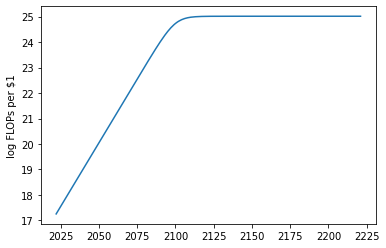

In [175]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [176]:
for y in years:
    print('Year: {} - log {} FLOPs per $ ({})'.format(y,
                                                      np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                      numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.3 FLOPs per $ (100 quadrillion)
Year: 2023 - log 17.4 FLOPs per $ (100 quadrillion)
Year: 2024 - log 17.5 FLOPs per $ (100 quadrillion)
Year: 2025 - log 17.6 FLOPs per $ (100 quadrillion)
Year: 2026 - log 17.7 FLOPs per $ (100 quadrillion)
Year: 2027 - log 17.8 FLOPs per $ (100 quadrillion)
Year: 2028 - log 17.9 FLOPs per $ (100 quadrillion)
Year: 2029 - log 18.0 FLOPs per $ (100 quadrillion)
Year: 2030 - log 18.1 FLOPs per $ (one quintillion)
Year: 2031 - log 18.2 FLOPs per $ (one quintillion)
Year: 2032 - log 18.3 FLOPs per $ (one quintillion)
Year: 2033 - log 18.4 FLOPs per $ (one quintillion)
Year: 2034 - log 18.5 FLOPs per $ (one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (one quintillion)
Year: 2040 - log 19.1 FLOPs per $ (10 quintillion)
Year: 2041 - 

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

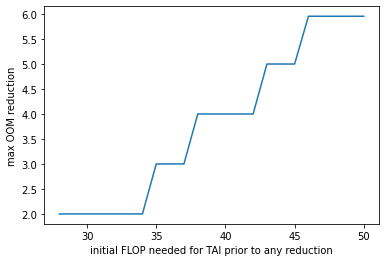

In [177]:
tai_sizes = range(28, 51)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')

In [178]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                            max_reduction_p[GRAPH_P],
                                                                                            t)))
          

TAI log FLOP 28 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 29 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 30 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 31 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 32 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 33 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 34 -> 1.9955447243483122 OOM reductions possible
TAI log FLOP 35 -> 2.995544724348312 OOM reductions possible
TAI log FLOP 36 -> 2.995544724348312 OOM reductions possible
TAI log FLOP 37 -> 2.995544724348312 OOM reductions possible
TAI log FLOP 38 -> 3.995544724348312 OOM reductions possible
TAI log FLOP 39 -> 3.995544724348312 OOM reductions possible
TAI log FLOP 40 -> 3.995544724348312 OOM reductions possible
TAI log FLOP 41 -> 3.995544724348312 OOM reductions possible
TAI log FLOP 42 -> 3.995544724348312 OOM reductions possible
TAI log FLOP 43 -> 4.995544724348312 OOM reductions possible
TAI log FLOP 44 -

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

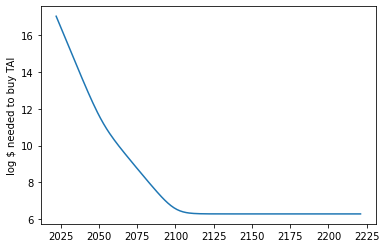

In [179]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [180]:
for y in years:
    print('Year: {} - log $ {} to buy TAI ({})'.format(y,
                                                       np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 17.0 to buy TAI (100 quadrillion)
Year: 2023 - log $ 16.8 to buy TAI (10 quadrillion)
Year: 2024 - log $ 16.6 to buy TAI (10 quadrillion)
Year: 2025 - log $ 16.4 to buy TAI (10 quadrillion)
Year: 2026 - log $ 16.2 to buy TAI (10 quadrillion)
Year: 2027 - log $ 16.0 to buy TAI (10 quadrillion)
Year: 2028 - log $ 15.8 to buy TAI (one quadrillion)
Year: 2029 - log $ 15.6 to buy TAI (one quadrillion)
Year: 2030 - log $ 15.4 to buy TAI (one quadrillion)
Year: 2031 - log $ 15.2 to buy TAI (one quadrillion)
Year: 2032 - log $ 15.0 to buy TAI (one quadrillion)
Year: 2033 - log $ 14.8 to buy TAI (100 trillion)
Year: 2034 - log $ 14.6 to buy TAI (100 trillion)
Year: 2035 - log $ 14.4 to buy TAI (100 trillion)
Year: 2036 - log $ 14.2 to buy TAI (100 trillion)
Year: 2037 - log $ 14.0 to buy TAI (100 trillion)
Year: 2038 - log $ 13.8 to buy TAI (10 trillion)
Year: 2039 - log $ 13.6 to buy TAI (10 trillion)
Year: 2040 - log $ 13.4 to buy TAI (10 trillion)
Year: 2041 - log $ 13.3 t

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

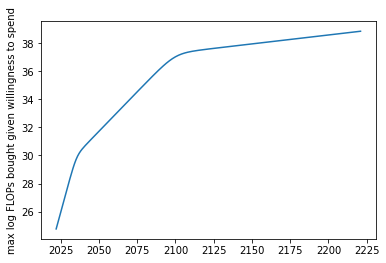

In [181]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [182]:
for y in years:
    print('Year: {} - max log FLOPs {} ({})'.format(y,
                                                    np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                    numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.8 (one septillion)
Year: 2023 - max log FLOPs 25.2 (10 septillion)
Year: 2024 - max log FLOPs 25.6 (10 septillion)
Year: 2025 - max log FLOPs 26.0 (10 septillion)
Year: 2026 - max log FLOPs 26.4 (100 septillion)
Year: 2027 - max log FLOPs 26.8 (100 septillion)
Year: 2028 - max log FLOPs 27.2 (one octillion)
Year: 2029 - max log FLOPs 27.6 (one octillion)
Year: 2030 - max log FLOPs 28.0 (one octillion)
Year: 2031 - max log FLOPs 28.3 (10 octillion)
Year: 2032 - max log FLOPs 28.7 (10 octillion)
Year: 2033 - max log FLOPs 29.1 (100 octillion)
Year: 2034 - max log FLOPs 29.4 (100 octillion)
Year: 2035 - max log FLOPs 29.7 (100 octillion)
Year: 2036 - max log FLOPs 30.0 (100 octillion)
Year: 2037 - max log FLOPs 30.2 (one nonillion)
Year: 2038 - max log FLOPs 30.3 (one nonillion)
Year: 2039 - max log FLOPs 30.5 (one nonillion)
Year: 2040 - max log FLOPs 30.6 (one nonillion)
Year: 2041 - max log FLOPs 30.7 (one nonillion)
Year: 2042 - max log FLOPs 30.8 (one no

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

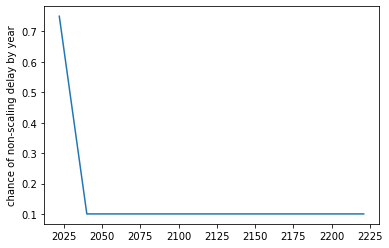

In [183]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years, p_nonscaling_delay_)
plt.ylabel('chance of non-scaling delay by year')

In [184]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 75.0%
Year: 2023 - p(nonscaling delay) = 71.4%
Year: 2024 - p(nonscaling delay) = 67.8%
Year: 2025 - p(nonscaling delay) = 64.2%
Year: 2026 - p(nonscaling delay) = 60.6%
Year: 2027 - p(nonscaling delay) = 56.9%
Year: 2028 - p(nonscaling delay) = 53.3%
Year: 2029 - p(nonscaling delay) = 49.7%
Year: 2030 - p(nonscaling delay) = 46.1%
Year: 2031 - p(nonscaling delay) = 42.5%
Year: 2032 - p(nonscaling delay) = 38.9%
Year: 2033 - p(nonscaling delay) = 35.3%
Year: 2034 - p(nonscaling delay) = 31.7%
Year: 2035 - p(nonscaling delay) = 28.1%
Year: 2036 - p(nonscaling delay) = 24.4%
Year: 2037 - p(nonscaling delay) = 20.8%
Year: 2038 - p(nonscaling delay) = 17.2%
Year: 2039 - p(nonscaling delay) = 13.6%
Year: 2040 - p(nonscaling delay) = 10.0%
Year: 2041 - p(nonscaling delay) = 10.0%
Year: 2042 - p(nonscaling delay) = 10.0%
Year: 2043 - p(nonscaling delay) = 10.0%
Year: 2044 - p(nonscaling delay) = 10.0%
Year: 2045 - p(nonscaling delay) = 10.0%
Year: 2046 - p(n

## Chance of Rapid Recursive Self-Improvement

Text(0.5, 0, 'percentage of TAI-level FLOP')

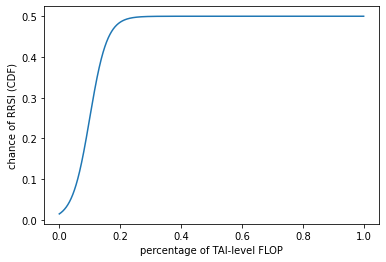

In [185]:
p_rrsi_ = np.array([p_rapid_recursive_self_improvement(10000,
                                                       x,
                                                       base_p_recursive,
                                                       recursive_curve_steepness,
                                                       recursive_curve_inflection) for x in range(10000)])

plt.plot([r / 10000 for r in range(10000)], p_rrsi_)
plt.ylabel('chance of RRSI (CDF)')
plt.xlabel('percentage of TAI-level FLOP')

In [186]:
samples = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
           1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i in samples:
    print('Ratio: {} in 10000 - p(RRSI) (CDF) = {}%'.format(i, np.round(p_rrsi_[i-1] * 100, 1)))

Ratio: 1 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 5 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 10 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 20 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 30 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 40 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 50 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 60 in 10000 - p(RRSI) (CDF) = 1.8%
Ratio: 70 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 80 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 90 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 100 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 200 in 10000 - p(RRSI) (CDF) = 2.9%
Ratio: 300 in 10000 - p(RRSI) (CDF) = 4.0%
Ratio: 400 in 10000 - p(RRSI) (CDF) = 5.4%
Ratio: 500 in 10000 - p(RRSI) (CDF) = 7.4%
Ratio: 600 in 10000 - p(RRSI) (CDF) = 9.9%
Ratio: 700 in 10000 - p(RRSI) (CDF) = 12.9%
Ratio: 800 in 10000 - p(RRSI) (CDF) = 16.6%
Ratio: 900 in 10000 - p(RRSI) (CDF) = 20.6%
Ratio: 1000 in 10000 - p(RRSI) (CDF) = 25.0%
Ratio: 1100 in 10000 - p(RRSI) (CDF) = 29.3%
Ratio: 1200 in 10000 - p(RRSI) (CDF) = 33.4%
Ratio: 1300 in 

## Run Model

Running
## RUN 1/10000 ##
Diagnostic: tai_flop_size=30.606442529751945, nonscaling_delay=5.3169690849685045, algo_doubling_rate=2.1883285223815734, possible_algo_reduction=2.786714524137212, initial_flops_per_dollar=2.3177221724678787e+17, flops_halving_rate=2.9936435624734434, max_flops_per_dollar=4.3404611140077664e+24, initial_pay=46284320.50453864, gdp_growth=1.0286568771068227, max_gdp_frac=0.0017800054569649686, willingness_ramp=0.7652763098929742, spend_doubling_time=0.853006348439439
-
It takes 30.6 log FLOPs (one nonillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.9x per year to a max of 0.0018% of GDP. GDP grows at a rate of 1.029x per year.
If we are 77.0% of the way to paying for TAI, 

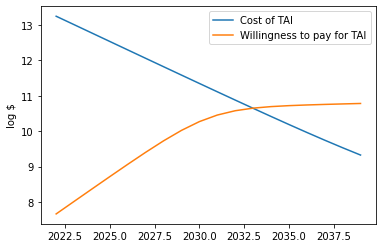

## RUN 2/10000 ##
Diagnostic: tai_flop_size=34.14023948105267, nonscaling_delay=1.9368633446676669, algo_doubling_rate=4.264940715473464, possible_algo_reduction=3.4757272235812215, initial_flops_per_dollar=2.2858560257033187e+17, flops_halving_rate=2.668734151882357, max_flops_per_dollar=1.4303932896071643e+25, initial_pay=32537838.524917167, gdp_growth=1.0214940761377813, max_gdp_frac=0.0065195030895909105, willingness_ramp=0.7951380715786376, spend_doubling_time=0.5
-
It takes 34.1 log FLOPs (10 decillion) for transformative capabilities.
Every 4.3 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.5x per year to a max of 0.0065% of GDP. GDP grows at a rate of 1.021x per year.
If we are 80.0% of the way to paying for TAI, we will ramp to paying fo

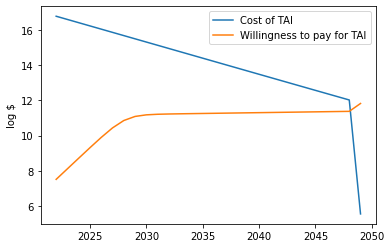

## RUN 3/10000 ##
Diagnostic: tai_flop_size=30.336533101022834, nonscaling_delay=5.43709860673274, algo_doubling_rate=1, possible_algo_reduction=2.1003853924468756, initial_flops_per_dollar=2.790171920140113e+17, flops_halving_rate=3.2170948382961018, max_flops_per_dollar=1.600610374608997e+25, initial_pay=17687689.85589858, gdp_growth=1.0254052035259604, max_gdp_frac=0.01374881626872432, willingness_ramp=0.8149577605236332, spend_doubling_time=0.8605449714862207
-
It takes 30.3 log FLOPs (one nonillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 0.9x per year to a max of 0.0137% of GDP. GDP grows at a rate of 1.025x per year.
If we are 81.0% of the way to paying for TAI, we will ramp to paying for TAI.


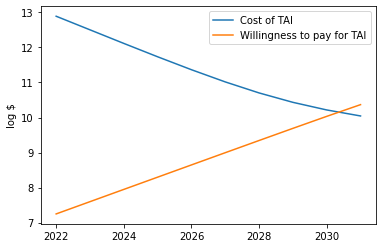

## RUN 4/10000 ##
Diagnostic: tai_flop_size=29.28243862994477, nonscaling_delay=2.114827499205015, algo_doubling_rate=3.2121159463557882, possible_algo_reduction=2.700773134010853, initial_flops_per_dollar=1.65373157275398e+17, flops_halving_rate=3.081887702759435, max_flops_per_dollar=7.808411205879946e+23, initial_pay=7164039.0501879165, gdp_growth=1.0339102354235339, max_gdp_frac=0.0026017857356363185, willingness_ramp=0.9555989753270597, spend_doubling_time=1.017551709894915
-
It takes 29.3 log FLOPs (100 octillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.1 years they get 2x cheaper, to a maximum of 23.9 log FLOPs (100 sextillion) per $.
We are willing to pay 6.9 log $ (one million) and this increases by 1.0x per year to a max of 0.0026% of GDP. GDP grows at a rate of 1.034x per year.
If we are 96.0% of the way to paying for TAI, we will ramp

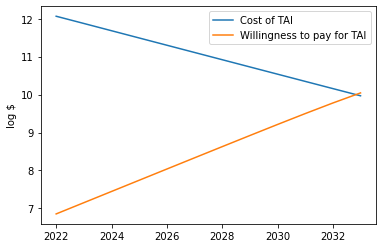

## RUN 5/10000 ##
Diagnostic: tai_flop_size=32.90268027026047, nonscaling_delay=6.0473386955349815, algo_doubling_rate=3.400166541366326, possible_algo_reduction=2.091020635468413, initial_flops_per_dollar=3.6995398600118784e+17, flops_halving_rate=3.487803327290801, max_flops_per_dollar=5.021004263551184e+24, initial_pay=58477374.78356941, gdp_growth=1.0295470115451992, max_gdp_frac=0.005815797353198415, willingness_ramp=0.867354824458216, spend_doubling_time=1.3616643567040945
-
It takes 32.9 log FLOPs (100 nonillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 17.6 log FLOPs (100 quadrillion) per $. Every 3.5 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.4x per year to a max of 0.0058% of GDP. GDP grows at a rate of 1.03x per year.
If we are 87.0% of the way to paying for TAI, we will ramp t

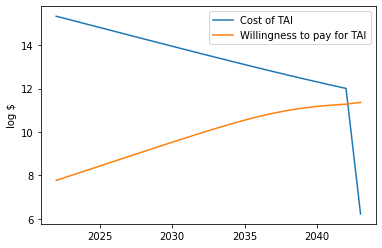

## RUN 6/10000 ##
Diagnostic: tai_flop_size=32.59996239636136, nonscaling_delay=2.823023249102242, algo_doubling_rate=4.5816880099817645, possible_algo_reduction=0.9488230574918082, initial_flops_per_dollar=1.4881172272787107e+17, flops_halving_rate=3.4525723394662027, max_flops_per_dollar=2.3308592960611735e+25, initial_pay=59746565.78414828, gdp_growth=1.0247344084637555, max_gdp_frac=0.0068078598159375964, willingness_ramp=0.8879184629057467, spend_doubling_time=1.6663287445522104
-
It takes 32.6 log FLOPs (100 nonillion) for transformative capabilities.
Every 4.6 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.5 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.8 log $ (10 million) and this increases by 1.7x per year to a max of 0.0068% of GDP. GDP grows at a rate of 1.025x per year.
If we are 89.0% of the way to paying for TAI, we will r

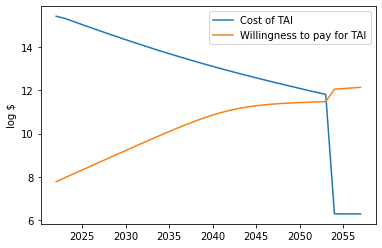

## RUN 7/10000 ##
Diagnostic: tai_flop_size=35.34338422623265, nonscaling_delay=11.547443086433246, algo_doubling_rate=3.9434405716005223, possible_algo_reduction=2.9767363829852247, initial_flops_per_dollar=2.391595277054023e+17, flops_halving_rate=3.9201594669795163, max_flops_per_dollar=8.445138941219594e+24, initial_pay=5653786.900628203, gdp_growth=1.0283616122772399, max_gdp_frac=0.0017807535247182996, willingness_ramp=1.0123296844225962, spend_doubling_time=0.844551740272439
-
It takes 35.3 log FLOPs (100 decillion) for transformative capabilities.
Every 3.9 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 24.9 log FLOPs (one septillion) per $.
We are willing to pay 6.8 log $ (one million) and this increases by 0.8x per year to a max of 0.0018% of GDP. GDP grows at a rate of 1.028x per year.
If we are 101.0% of the way to paying for TAI, we will 

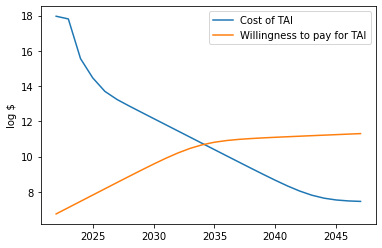

## RUN 8/10000 ##
Diagnostic: tai_flop_size=40.80898109019501, nonscaling_delay=1.3878664056204815, algo_doubling_rate=2.607241914789969, possible_algo_reduction=2.2604112262442175, initial_flops_per_dollar=1.052602244154071e+17, flops_halving_rate=3.314577940318246, max_flops_per_dollar=3.1730348159563195e+24, initial_pay=79433845.75628503, gdp_growth=1.027211972220661, max_gdp_frac=0.0015, willingness_ramp=0.8869611616675892, spend_doubling_time=1.5574061873195766
-
It takes 40.8 log FLOPs (10 million decillion) for transformative capabilities.
Every 2.6 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 1.6x per year to a max of 0.0015% of GDP. GDP grows at a rate of 1.027x per year.
If we are 89.0% of the way to paying for TAI, we will ramp to pay

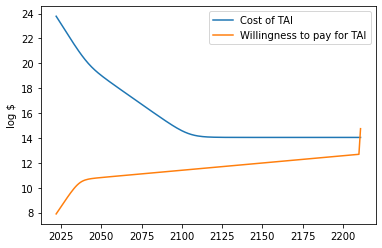

## RUN 9/10000 ##
Diagnostic: tai_flop_size=29.91781820080201, nonscaling_delay=11.323614425364422, algo_doubling_rate=2.516332145979293, possible_algo_reduction=0.8616917480067856, initial_flops_per_dollar=1.7142720304763798e+17, flops_halving_rate=3.4163001722665327, max_flops_per_dollar=8.75526433621857e+24, initial_pay=42502085.13504102, gdp_growth=1.0297468197182895, max_gdp_frac=0.00372710799682316, willingness_ramp=0.983137382195713, spend_doubling_time=1.273092928294414
-
It takes 29.9 log FLOPs (100 octillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 0.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 24.9 log FLOPs (one septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 1.3x per year to a max of 0.0037% of GDP. GDP grows at a rate of 1.03x per year.
If we are 98.0% of the way to paying for TAI, we will ramp to

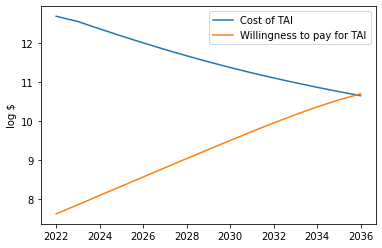

## RUN 10/10000 ##
Diagnostic: tai_flop_size=35.96060087890264, nonscaling_delay=5.721973284429683, algo_doubling_rate=3.7003696489754243, possible_algo_reduction=4.02717253118878, initial_flops_per_dollar=3.6830283092316397e+17, flops_halving_rate=3.6252422348119473, max_flops_per_dollar=2.820733791879381e+24, initial_pay=10499044.483156454, gdp_growth=1.0236955113412252, max_gdp_frac=0.004315189899028765, willingness_ramp=0.8090882735181646, spend_doubling_time=1.2835083732848827
-
It takes 36.0 log FLOPs (100 decillion) for transformative capabilities.
Every 3.7 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 17.6 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.0 log $ (10 million) and this increases by 1.3x per year to a max of 0.0043% of GDP. GDP grows at a rate of 1.024x per year.
If we are 81.0% of the way to paying for TAI, we will ra

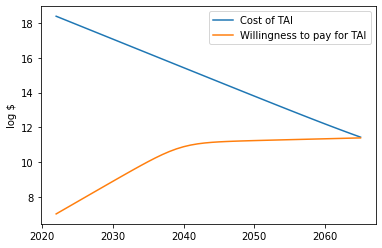

## RUN 11/10000 ##
Diagnostic: tai_flop_size=39.0997077507268, nonscaling_delay=3.8022304045770317, algo_doubling_rate=2.6501582374195185, possible_algo_reduction=4.213233306180589, initial_flops_per_dollar=4.1498179254104896e+17, flops_halving_rate=3.2927401565281786, max_flops_per_dollar=1.6839186996288781e+25, initial_pay=73866143.08106889, gdp_growth=1.0401358396206895, max_gdp_frac=0.009359941294720293, willingness_ramp=0.9206187944299984, spend_doubling_time=0.9639614271516553
-
It takes 39.1 log FLOPs (one million decillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 4.2 log reductions possible.
FLOPs start at a cost of 17.6 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 1.0x per year to a max of 0.0094% of GDP. GDP grows at a rate of 1.04x per year.
If we are 92.0% of the way to paying for TAI, we 

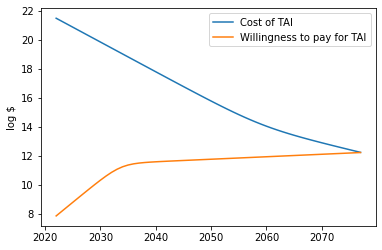

## RUN 12/10000 ##
Diagnostic: tai_flop_size=37.883361609232274, nonscaling_delay=3.0450627332113, algo_doubling_rate=2.087485030573152, possible_algo_reduction=2.94271499218042, initial_flops_per_dollar=6.698046009184277e+16, flops_halving_rate=2.964526108641771, max_flops_per_dollar=8.013090978834278e+24, initial_pay=39969529.545291975, gdp_growth=1.0190108610753337, max_gdp_frac=0.0052208840695460125, willingness_ramp=0.9113460621146247, spend_doubling_time=1.7716260855761374
-
It takes 37.9 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 16.8 log FLOPs (10 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.9 log FLOPs (one septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 1.8x per year to a max of 0.0052% of GDP. GDP grows at a rate of 1.019x per year.
If we are 91.0% of the way to paying for TAI, we wil

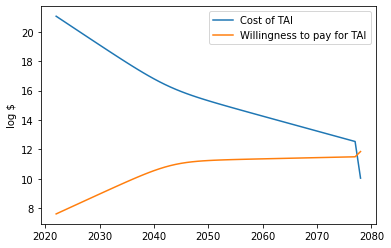

## RUN 13/10000 ##
Diagnostic: tai_flop_size=26.783917720465574, nonscaling_delay=7.572294783533955, algo_doubling_rate=3.766525340437396, possible_algo_reduction=2.231370419194831, initial_flops_per_dollar=2.3399245154230992e+17, flops_halving_rate=4.1975829452422175, max_flops_per_dollar=2.5723289516099783e+25, initial_pay=93105808.73338208, gdp_growth=1.0216646515303784, max_gdp_frac=0.001603171492026088, willingness_ramp=0.854413754519929, spend_doubling_time=1.402242131833537
-
It takes 26.8 log FLOPs (100 septillion) for transformative capabilities.
Every 3.8 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 4.2 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 1.4x per year to a max of 0.0016% of GDP. GDP grows at a rate of 1.022x per year.
If we are 85.0% of the way to paying for TAI, we will ram

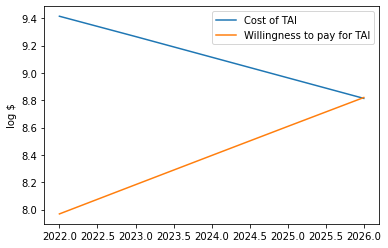

## RUN 14/10000 ##
Diagnostic: tai_flop_size=32.849830842063355, nonscaling_delay=1.562445777018643, algo_doubling_rate=3.4327539393621276, possible_algo_reduction=1.7565475143250888, initial_flops_per_dollar=3.1641005698341734e+17, flops_halving_rate=3.4340731301627136, max_flops_per_dollar=5.972023436860284e+24, initial_pay=27157087.70077572, gdp_growth=1.0289224750743375, max_gdp_frac=0.020184838450206858, willingness_ramp=0.9501172940266401, spend_doubling_time=0.9011066925801382
-
It takes 32.8 log FLOPs (100 nonillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.9x per year to a max of 0.0202% of GDP. GDP grows at a rate of 1.029x per year.
If we are 95.0% of the way to paying for TAI, we will 

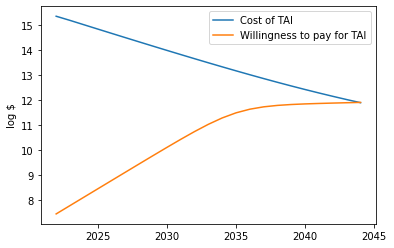

## RUN 15/10000 ##
Diagnostic: tai_flop_size=23.04486159630595, nonscaling_delay=19.158534643817553, algo_doubling_rate=4.452446368153798, possible_algo_reduction=2.7898416978839737, initial_flops_per_dollar=1.6690016265364582e+17, flops_halving_rate=4.188638581523772, max_flops_per_dollar=1.009591340447696e+25, initial_pay=78136575.27095722, gdp_growth=1.021309848450176, max_gdp_frac=0.006300569209513105, willingness_ramp=0.8725169842486729, spend_doubling_time=0.7040968669865014
-
It takes 23.0 log FLOPs (100 sextillion) for transformative capabilities.
Every 4.5 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 4.2 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (10 septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 0.7x per year to a max of 0.0063% of GDP. GDP grows at a rate of 1.021x per year.
If we are 87.0% of the way to paying for TAI, we will ram

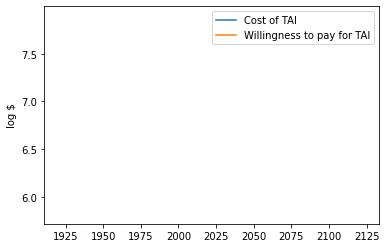

## RUN 16/10000 ##
Diagnostic: tai_flop_size=35.31673196586013, nonscaling_delay=3.382660219710467, algo_doubling_rate=4.417794560124671, possible_algo_reduction=3.8872249550396263, initial_flops_per_dollar=1.4045096283721406e+17, flops_halving_rate=3.3823807542687954, max_flops_per_dollar=2.0084401120494705e+24, initial_pay=53313396.87506698, gdp_growth=1.0354242358286636, max_gdp_frac=0.01051318131953814, willingness_ramp=1.1191960476020635, spend_doubling_time=1.5836077386711516
-
It takes 35.3 log FLOPs (100 decillion) for transformative capabilities.
Every 4.4 years algorithms get 2x better, with 3.9 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 24.3 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 1.6x per year to a max of 0.0105% of GDP. GDP grows at a rate of 1.035x per year.
If we are 112.0% of the way to paying for TAI, we will r

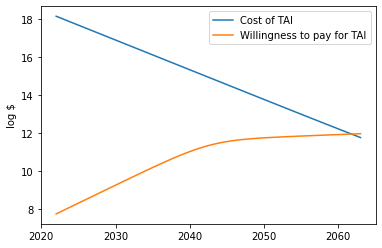

## RUN 17/10000 ##
Diagnostic: tai_flop_size=31.42091476489414, nonscaling_delay=19.99103577529386, algo_doubling_rate=4.053589517003829, possible_algo_reduction=1.1484372129455998, initial_flops_per_dollar=1.3402518169719574e+17, flops_halving_rate=4.0141620194860455, max_flops_per_dollar=1.0353891084278417e+25, initial_pay=25764050.3831735, gdp_growth=1.0251296854502063, max_gdp_frac=0.0033264832025494987, willingness_ramp=0.8508189139092758, spend_doubling_time=0.8298722311247546
-
It takes 31.4 log FLOPs (10 nonillion) for transformative capabilities.
Every 4.1 years algorithms get 2x better, with 1.1 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 4.0 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.8x per year to a max of 0.0033% of GDP. GDP grows at a rate of 1.025x per year.
If we are 85.0% of the way to paying for TAI, we will ram

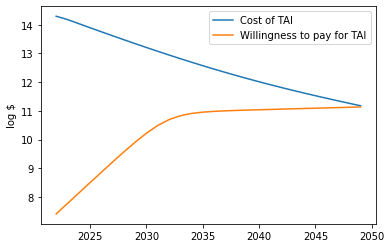

## RUN 18/10000 ##
Diagnostic: tai_flop_size=29.806714361217228, nonscaling_delay=1.9483994466882102, algo_doubling_rate=1.4536133346550018, possible_algo_reduction=1.6196608713382576, initial_flops_per_dollar=2.1996066500344832e+17, flops_halving_rate=3.352972604783331, max_flops_per_dollar=1.5189127009481787e+25, initial_pay=35482310.89260455, gdp_growth=1.0379955135300172, max_gdp_frac=0.00227775169895865, willingness_ramp=0.9043640874548121, spend_doubling_time=0.7826636551907049
-
It takes 29.8 log FLOPs (100 octillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.4 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.8x per year to a max of 0.0023% of GDP. GDP grows at a rate of 1.038x per year.
If we are 90.0% of the way to paying for TAI, we will r

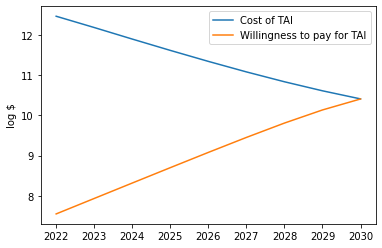

## RUN 19/10000 ##
Diagnostic: tai_flop_size=39.9597890666052, nonscaling_delay=2.541111414819676, algo_doubling_rate=2.7771625106341147, possible_algo_reduction=3.7254928997787733, initial_flops_per_dollar=1.6402318224692176e+17, flops_halving_rate=3.214351069715945, max_flops_per_dollar=1.5083700947124595e+24, initial_pay=92510468.46357644, gdp_growth=1.039686051532448, max_gdp_frac=0.0047135513547781616, willingness_ramp=0.7154921723796174, spend_doubling_time=0.9718974558118484
-
It takes 40.0 log FLOPs (one million decillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 24.2 log FLOPs (one septillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 1.0x per year to a max of 0.0047% of GDP. GDP grows at a rate of 1.04x per year.
If we are 72.0% of the way to paying for TAI, we 

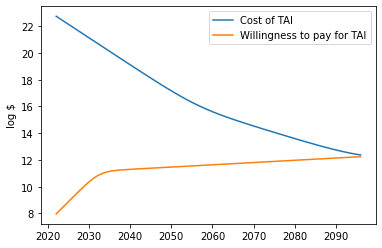

## RUN 20/10000 ##
Diagnostic: tai_flop_size=41.89556200051513, nonscaling_delay=5.705453653401169, algo_doubling_rate=2.8718514499807033, possible_algo_reduction=3.5653941797460567, initial_flops_per_dollar=1.2995841597620859e+17, flops_halving_rate=1.9057623339948517, max_flops_per_dollar=4.105602235903659e+24, initial_pay=101089653.86744946, gdp_growth=1.0217046262422955, max_gdp_frac=0.036734209349012066, willingness_ramp=0.7718899363344822, spend_doubling_time=1.1248194343745757
-
It takes 41.9 log FLOPs (100 million decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 3.6 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 1.9 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 8.0 log $ (100 million) and this increases by 1.1x per year to a max of 0.0367% of GDP. GDP grows at a rate of 1.022x per year.
If we are 77.0% of the way to paying for TAI,

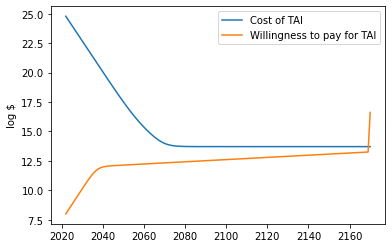

## RUN 21/10000 ##
Diagnostic: tai_flop_size=34.29344704427558, nonscaling_delay=8.235764607782519, algo_doubling_rate=3.5429061250565015, possible_algo_reduction=3.0827111516865906, initial_flops_per_dollar=1.360851413092603e+17, flops_halving_rate=3.316605359370109, max_flops_per_dollar=4.96916188734817e+24, initial_pay=35211533.44572743, gdp_growth=1.0229050402967346, max_gdp_frac=0.005393086200811181, willingness_ramp=0.920551887591295, spend_doubling_time=0.7921004903292606
-
It takes 34.3 log FLOPs (10 decillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 3.1 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.8x per year to a max of 0.0054% of GDP. GDP grows at a rate of 1.023x per year.
If we are 92.0% of the way to paying for TAI, we will ramp t

--- rapid recursive loop (p=0.061691390613676095, r_=0.03823196608201129) - set flops_having_rate=0.7716876118130346, algo_doubling_rate=0.6786553456624657 spend_doubling_time=0.7921004903292606, gdp_growth=1.0839060051733513, initial_chance_of_nonscaling_issue=0.75 final_chance_of_nonscaling_issue=0.1
Year: 2053 - 36.8 max log FLOP (one thousand decillion) available - TAI takes 31.2 log FLOP (10 nonillion) - log $ 6.5 to buy TAI (one million) vs. willingness to pay log $ 12.1 (one trillion) - 24.7 log FLOPS per $ (one septillion)
-- Nonscaling issue did not occur p_nonscaling_issue=0.1 r_=0.6395
--- /!\ TAI CREATED in 2053


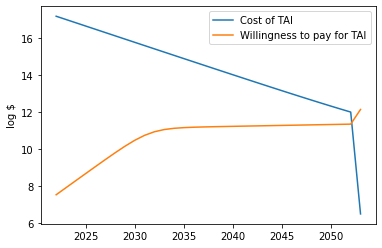

## RUN 22/10000 ##
Diagnostic: tai_flop_size=24.34428710530878, nonscaling_delay=11.604044723333914, algo_doubling_rate=3.1370501088405254, possible_algo_reduction=1.8296341286252331, initial_flops_per_dollar=2.419178579306724e+17, flops_halving_rate=3.8542591722318793, max_flops_per_dollar=8.474341732658458e+25, initial_pay=31206843.210872244, gdp_growth=1.035511524707192, max_gdp_frac=0.0037923996532277693, willingness_ramp=0.7754915885617819, spend_doubling_time=1.2593159270177159
-
It takes 24.3 log FLOPs (one septillion) for transformative capabilities.
Every 3.1 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 25.9 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.3x per year to a max of 0.0038% of GDP. GDP grows at a rate of 1.036x per year.
If we are 78.0% of the way to paying for TAI, we will 

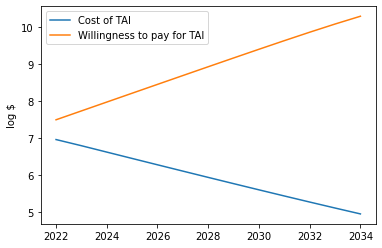

## RUN 23/10000 ##
Diagnostic: tai_flop_size=35.635100373644185, nonscaling_delay=7.174889927274765, algo_doubling_rate=2.46784995239165, possible_algo_reduction=3.7669623603489253, initial_flops_per_dollar=2.06267000176612e+17, flops_halving_rate=2.782714145484435, max_flops_per_dollar=5.756838562954311e+24, initial_pay=18870480.097121537, gdp_growth=1.0352444974137676, max_gdp_frac=0.002686715081420133, willingness_ramp=0.8006922278937049, spend_doubling_time=0.6658689563927671
-
It takes 35.6 log FLOPs (100 decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 0.7x per year to a max of 0.0027% of GDP. GDP grows at a rate of 1.035x per year.
If we are 80.0% of the way to paying for TAI, we will ramp

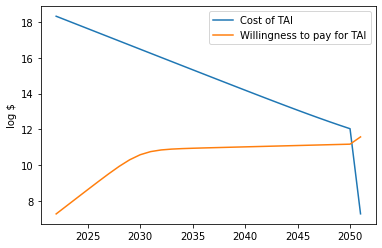

## RUN 24/10000 ##
Diagnostic: tai_flop_size=35.90544777005503, nonscaling_delay=47.55415928289707, algo_doubling_rate=4.049847791958042, possible_algo_reduction=3.308904046185962, initial_flops_per_dollar=1.6209331005174464e+17, flops_halving_rate=3.016721830518895, max_flops_per_dollar=5.273812909243398e+24, initial_pay=34697791.80521094, gdp_growth=1.0293136289081886, max_gdp_frac=0.005582877070499267, willingness_ramp=0.9322281197629994, spend_doubling_time=1.4537272073361982
-
It takes 35.9 log FLOPs (100 decillion) for transformative capabilities.
Every 4.0 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.5x per year to a max of 0.0056% of GDP. GDP grows at a rate of 1.029x per year.
If we are 93.0% of the way to paying for TAI, we will ramp

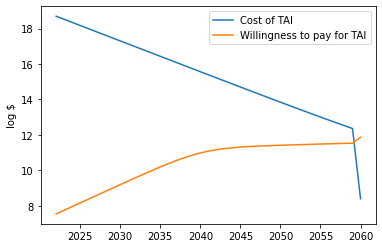

## RUN 25/10000 ##
Diagnostic: tai_flop_size=30.934481769555894, nonscaling_delay=8.170763581655912, algo_doubling_rate=2.4673956584674874, possible_algo_reduction=2.8773255716295694, initial_flops_per_dollar=1.8721523089114797e+17, flops_halving_rate=3.284602292834276, max_flops_per_dollar=3.183180564746794e+24, initial_pay=16673049.445429256, gdp_growth=1.0302871307073123, max_gdp_frac=0.0035852304057731503, willingness_ramp=0.7762897658708244, spend_doubling_time=2.4775351007541753
-
It takes 30.9 log FLOPs (one nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 2.5x per year to a max of 0.0036% of GDP. GDP grows at a rate of 1.03x per year.
If we are 78.0% of the way to paying for TAI, we will 

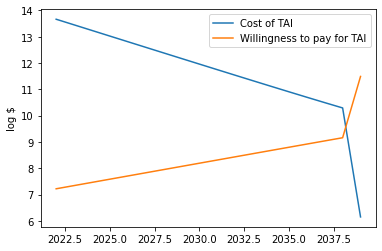

## RUN 26/10000 ##
Diagnostic: tai_flop_size=38.213534867543856, nonscaling_delay=15.530158731983379, algo_doubling_rate=4.376053298228534, possible_algo_reduction=2.9072872752780947, initial_flops_per_dollar=2.533380905004923e+17, flops_halving_rate=2.468245028631044, max_flops_per_dollar=5.872957087239247e+24, initial_pay=94953968.02826288, gdp_growth=1.024553724926977, max_gdp_frac=0.007815461771674307, willingness_ramp=0.8646702584704499, spend_doubling_time=1.0903399144318446
-
It takes 38.2 log FLOPs (100 thousand decillion) for transformative capabilities.
Every 4.4 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 1.1x per year to a max of 0.0078% of GDP. GDP grows at a rate of 1.025x per year.
If we are 86.0% of the way to paying for TAI, we

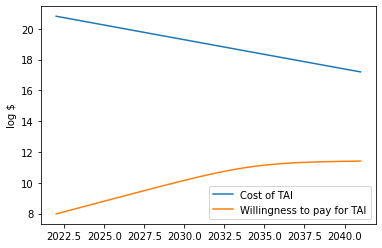

## RUN 27/10000 ##
Diagnostic: tai_flop_size=47.860597885631016, nonscaling_delay=6.144378532735175, algo_doubling_rate=2.1393089180607365, possible_algo_reduction=6.100905175528865, initial_flops_per_dollar=1.741978492222994e+17, flops_halving_rate=2.6770539479077837, max_flops_per_dollar=3.679047393148807e+24, initial_pay=20943160.906552732, gdp_growth=1.0212069509066501, max_gdp_frac=0.0037640765605851385, willingness_ramp=1.034303228870527, spend_doubling_time=1.5427352771719376
-
It takes 47.9 log FLOPs (100 trillion decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 6.1 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.7 years they get 2x cheaper, to a maximum of 24.6 log FLOPs (one septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 1.5x per year to a max of 0.0038% of GDP. GDP grows at a rate of 1.021x per year.
If we are 103.0% of the way to paying for TAI,

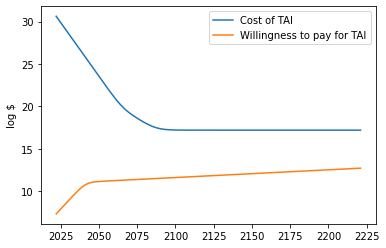

## RUN 28/10000 ##
Diagnostic: tai_flop_size=43.19034705367478, nonscaling_delay=6.017196117342109, algo_doubling_rate=2.9026298716517336, possible_algo_reduction=4.408504745612786, initial_flops_per_dollar=1.4772967040134378e+17, flops_halving_rate=1.65077418827621, max_flops_per_dollar=2.2406161444351423e+25, initial_pay=26974613.715549786, gdp_growth=1.035513237306746, max_gdp_frac=0.007279064226492686, willingness_ramp=0.7247402940702732, spend_doubling_time=1.2985352395560266
-
It takes 43.2 log FLOPs (10 billion decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 1.7 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.3x per year to a max of 0.0073% of GDP. GDP grows at a rate of 1.036x per year.
If we are 72.0% of the way to paying for TAI, we wi

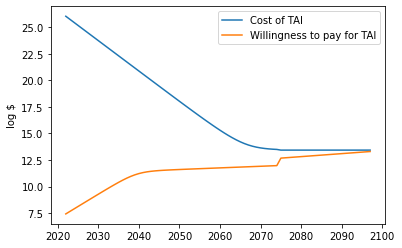

## RUN 29/10000 ##
Diagnostic: tai_flop_size=34.335059588242075, nonscaling_delay=10.147485753424055, algo_doubling_rate=1, possible_algo_reduction=3.567352892458591, initial_flops_per_dollar=2.0307307300322032e+17, flops_halving_rate=1.8303434893929147, max_flops_per_dollar=5.832377621749262e+24, initial_pay=32377073.62491256, gdp_growth=1.0302460882835982, max_gdp_frac=0.0022648632661098184, willingness_ramp=0.8014137885326607, spend_doubling_time=1.775653633122754
-
It takes 34.3 log FLOPs (10 decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 1.8 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.8x per year to a max of 0.0023% of GDP. GDP grows at a rate of 1.03x per year.
If we are 80.0% of the way to paying for TAI, we will ramp to paying for TA

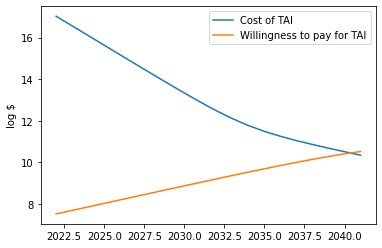

## RUN 30/10000 ##
Diagnostic: tai_flop_size=43.105349624898885, nonscaling_delay=10.470971848783044, algo_doubling_rate=1.2146909014395004, possible_algo_reduction=4.70919309700238, initial_flops_per_dollar=1.6517012734885504e+17, flops_halving_rate=4.140715098467339, max_flops_per_dollar=3.5455779209077385e+24, initial_pay=11132792.777853375, gdp_growth=1.024495600522937, max_gdp_frac=0.003106662266498164, willingness_ramp=0.8099478134700305, spend_doubling_time=1.9235322135786914
-
It takes 43.1 log FLOPs (10 billion decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 4.7 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 4.1 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.0 log $ (10 million) and this increases by 1.9x per year to a max of 0.0031% of GDP. GDP grows at a rate of 1.024x per year.
If we are 81.0% of the way to paying for TAI, we

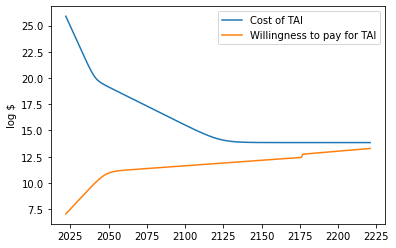

## RUN 101/10000 ##
## RUN 201/10000 ##
## RUN 301/10000 ##
## RUN 401/10000 ##
## RUN 501/10000 ##
## RUN 601/10000 ##
## RUN 701/10000 ##
## RUN 801/10000 ##
## RUN 901/10000 ##
## RUN 1001/10000 ##
## RUN 1101/10000 ##
## RUN 1201/10000 ##
## RUN 1301/10000 ##
## RUN 1401/10000 ##
## RUN 1501/10000 ##
## RUN 1601/10000 ##
## RUN 1701/10000 ##
## RUN 1801/10000 ##
## RUN 1901/10000 ##
## RUN 2001/10000 ##
## RUN 2101/10000 ##
## RUN 2201/10000 ##
## RUN 2301/10000 ##
## RUN 2401/10000 ##
## RUN 2501/10000 ##
## RUN 2601/10000 ##
## RUN 2701/10000 ##
## RUN 2801/10000 ##
## RUN 2901/10000 ##
## RUN 3001/10000 ##
## RUN 3101/10000 ##
## RUN 3201/10000 ##
## RUN 3301/10000 ##
## RUN 3401/10000 ##
## RUN 3501/10000 ##
## RUN 3601/10000 ##
## RUN 3701/10000 ##
## RUN 3801/10000 ##
## RUN 3901/10000 ##
## RUN 4001/10000 ##
## RUN 4101/10000 ##
## RUN 4201/10000 ##
## RUN 4301/10000 ##
## RUN 4401/10000 ##
## RUN 4501/10000 ##
## RUN 4601/10000 ##
## RUN 4701/10000 ##
## RUN 4801/10000 ##
#

In [187]:
tai_years = []
tai_flop_size_log_ = []
plt.ioff()
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 100 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    tai_flop_size_ = sample(tai_flop_size, credibility=CREDIBLE_INTERVAL)  # TODO: DRY out `, credibility=CREDIBLE_INTERVAL`
    tai_flop_size_log_.append(tai_flop_size_)
    algo_doubling_rate_ = sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction, credibility=CREDIBLE_INTERVAL),
                                                          sample(max_reduction, credibility=CREDIBLE_INTERVAL),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    flops_halving_rate_ = sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    initial_pay_ = 10 ** sample(initial_pay, credibility=CREDIBLE_INTERVAL)
    gdp_growth_ = sample(gdp_growth, credibility=CREDIBLE_INTERVAL)
    max_gdp_frac_ = sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL)
    willingness_ramp_ = sample(willingness_ramp, credibility=CREDIBLE_INTERVAL)
    spend_doubling_time_ = sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL)
    nonscaling_delay_ = sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    
    if print_diagnostic:
        diagnostic = 'Diagnostic: tai_flop_size={}, nonscaling_delay={}, algo_doubling_rate={}, '
        diagnostic += 'possible_algo_reduction={}, initial_flops_per_dollar={}, flops_halving_rate={}, '
        diagnostic += 'max_flops_per_dollar={}, initial_pay={}, gdp_growth={}, max_gdp_frac={}, '
        diagnostic += 'willingness_ramp={}, spend_doubling_time={}'
        print(diagnostic.format(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
                                possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
                                max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
                                willingness_ramp_, spend_doubling_time_))
        # TODO: add other recursive variables
        print('-')

        print('It takes {} log FLOPs ({}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                   numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs ({}) per $. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs ({}) per $.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                              numerize(math.log10(initial_flops_per_dollar_)),
                                                                              np.round(flops_halving_rate_, 1),
                                                                              np.round(math.log10(max_flops_per_dollar_), 1),
                                                                              numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log $ ({}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        print('If we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    recursive = False
    for y in years:
        if not tai_created:  
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                
            cost_of_tai_ = flops_needed_ / flops_per_dollar_
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            p_recursive = p_rapid_recursive_self_improvement(flops_needed_,
                                                             total_compute_,
                                                             base_p_recursive,
                                                             recursive_curve_steepness,
                                                             recursive_curve_inflection)
            p_recursive = p_recursive / 8 # Attempt to turn CDF into PDF (approximation)
            
            cost_of_tai_collector.append(cost_of_tai_)
            willingness_collector.append(willingness_)
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ * willingness_ramp_ <= willingness_:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                             final_chance_of_nonscaling_issue,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            
            r_ = random.random()
            if not tai_created and not is_nonscaling_issue and not recursive and r_ < p_recursive:
                flops_halving_rate__ = sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL)
                flops_halving_rate_ = flops_halving_rate__ if flops_halving_rate__ < flops_halving_rate_ else flops_halving_rate_
                algo_doubling_rate__ = sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
                algo_doubling_rate_ = algo_doubling_rate__ if algo_doubling_rate__ < algo_doubling_rate_ else algo_doubling_rate_
                spend_doubling_time__ = sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL)
                spend_doubling_time_ = spend_doubling_time__ if spend_doubling_time__ < spend_doubling_time_ else spend_doubling_time_
                gdp_growth__ = sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL)
                gdp_growth_ = gdp_growth__ if gdp_growth__ > gdp_growth_ else gdp_growth_
                initial_chance_of_nonscaling_issue_ = recursive_initial_chance_of_nonscaling_issue
                final_chance_of_nonscaling_issue_ = recursive_final_chance_of_nonscaling_issue
                recursive = True
                # TODO: fix issue where this changes the variables as of 2022 rather than as of the time of the rapid recursion

                if print_diagnostic:
                    print(('--- rapid recursive loop (p={}, r_={}) - set flops_having_rate={}, algo_doubling_rate={} ' +
                           'spend_doubling_time={}, gdp_growth={}, initial_chance_of_nonscaling_issue={} ' +
                           'final_chance_of_nonscaling_issue={}').format(p_recursive,
                                                                         r_,
                                                                         flops_halving_rate_,
                                                                         algo_doubling_rate_,
                                                                         spend_doubling_time_,
                                                                         gdp_growth_,
                                                                         initial_chance_of_nonscaling_issue,
                                                                         final_chance_of_nonscaling_issue))
                if event_occurs(p_recursive_creates_tai_instantly):
                    if print_diagnostic:
                        print('--- /!\ RRSI LOOP CREATES TAI in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                        
            elif not tai_created and not is_nonscaling_issue and not recursive and print_diagnostic:
                print('--- no rapid recursive loop (p={}, r_={})'.format(p_recursive, r_))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        tai_years.append(MAX_YEAR + 1)


In [188]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Jul 21 11:03PM CT):
#['5%: 2027',
# '10%: 2030',
# '20%: 2035',
# '30%: 2040',
# '40%: 2046',
# '50%: 2054',
# '60%: 2063',
# '70%: 2074',
# '80%: 2091',
# '90%: 2155',
# '95%: >2222']


['5%: 2027',
 '10%: 2030',
 '20%: 2035',
 '30%: 2040',
 '40%: 2046',
 '50%: 2054',
 '60%: 2063',
 '70%: 2074',
 '80%: 2091',
 '90%: 2155',
 '95%: >2222']

In [189]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['5%: 5 years from now',
 '10%: 8 years from now',
 '20%: 13 years from now',
 '30%: 18 years from now',
 '40%: 24 years from now',
 '50%: 32 years from now',
 '60%: 41 years from now',
 '70%: 52 years from now',
 '80%: 69 years from now',
 '90%: 133 years from now',
 '95%: >200 years from now']

In [190]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <2 years')
print_chance_tai_by_year(tai_years, 2023)


## Within <2 years


'1% chance of TAI by EOY 2023'

In [191]:
print_chance_tai_by_year(tai_years, 2024)

'2% chance of TAI by EOY 2024'

In [192]:
print_chance_tai_by_year(tai_years, 2025)

'3% chance of TAI by EOY 2025'

In [193]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'5% chance of TAI by EOY 2027'

In [194]:
print_chance_tai_by_year(tai_years, 2029)

'9% chance of TAI by EOY 2029'

In [195]:
print_chance_tai_by_year(tai_years, 2030)

'11% chance of TAI by EOY 2030'

In [196]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'15% chance of TAI by EOY 2032'

In [197]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'24% chance of TAI by EOY 2036'

In [198]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'26% chance of TAI by EOY 2037'

In [199]:
print_chance_tai_by_year(tai_years, 2039)

'29% chance of TAI by EOY 2039'

In [200]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'35% chance of TAI by EOY 2042'

In [201]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'42% chance of TAI by EOY 2047'

In [202]:
print_chance_tai_by_year(tai_years, 2049)

'45% chance of TAI by EOY 2049'

In [203]:
print_chance_tai_by_year(tai_years, 2059)

'56% chance of TAI by EOY 2059'

In [204]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'57% chance of TAI by EOY 2060'

In [205]:
print_chance_tai_by_year(tai_years, 2069)

'66% chance of TAI by EOY 2069'

In [206]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'67% chance of TAI by EOY 2070'

In [207]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'69% chance of TAI by EOY 2072'

In [208]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'73% chance of TAI by EOY 2078'

In [209]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'82% chance of TAI by EOY 2097'

In [210]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'83% chance of TAI by EOY 2100'

In [211]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'87% chance of TAI by EOY 2122'

In [212]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'93% chance of TAI by EOY 2222'

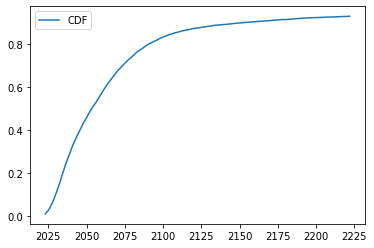

In [213]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

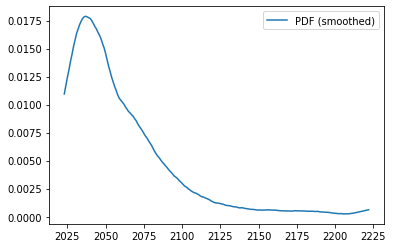

In [214]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [215]:
cdf[:len(bins)]

array([0.0115, 0.02  , 0.0286, 0.0397, 0.0542, 0.0688, 0.087 , 0.106 ,
       0.1267, 0.1462, 0.1668, 0.1911, 0.2134, 0.2351, 0.255 , 0.2739,
       0.2917, 0.3119, 0.3291, 0.3468, 0.3612, 0.3774, 0.3902, 0.405 ,
       0.4195, 0.4333, 0.4454, 0.4574, 0.4713, 0.4834, 0.496 , 0.507 ,
       0.5168, 0.527 , 0.5386, 0.55  , 0.5621, 0.5738, 0.5848, 0.5958,
       0.6055, 0.6163, 0.6256, 0.6351, 0.6451, 0.6542, 0.6626, 0.6719,
       0.6807, 0.6874, 0.6955, 0.7026, 0.7092, 0.7161, 0.724 , 0.7299,
       0.7363, 0.7422, 0.7488, 0.755 , 0.7621, 0.7669, 0.772 , 0.7761,
       0.7809, 0.7873, 0.7917, 0.7957, 0.8003, 0.8038, 0.8067, 0.81  ,
       0.8138, 0.8176, 0.8216, 0.825 , 0.8281, 0.8313, 0.8336, 0.8363,
       0.8394, 0.8425, 0.8443, 0.8464, 0.8488, 0.8515, 0.853 , 0.8544,
       0.8567, 0.8591, 0.8604, 0.8615, 0.863 , 0.8646, 0.8659, 0.8676,
       0.8694, 0.8712, 0.8718, 0.8732, 0.8743, 0.8761, 0.8772, 0.8788,
       0.8799, 0.8809, 0.8821, 0.8831, 0.8838, 0.885 , 0.8858, 0.8865,
      

In [216]:
pdf[:len(bins)]

array([0.0115, 0.0085, 0.0086, 0.0111, 0.0145, 0.0146, 0.0182, 0.019 ,
       0.0207, 0.0195, 0.0206, 0.0243, 0.0223, 0.0217, 0.0199, 0.0189,
       0.0178, 0.0202, 0.0172, 0.0177, 0.0144, 0.0162, 0.0128, 0.0148,
       0.0145, 0.0138, 0.0121, 0.012 , 0.0139, 0.0121, 0.0126, 0.011 ,
       0.0098, 0.0102, 0.0116, 0.0114, 0.0121, 0.0117, 0.011 , 0.011 ,
       0.0097, 0.0108, 0.0093, 0.0095, 0.01  , 0.0091, 0.0084, 0.0093,
       0.0088, 0.0067, 0.0081, 0.0071, 0.0066, 0.0069, 0.0079, 0.0059,
       0.0064, 0.0059, 0.0066, 0.0062, 0.0071, 0.0048, 0.0051, 0.0041,
       0.0048, 0.0064, 0.0044, 0.004 , 0.0046, 0.0035, 0.0029, 0.0033,
       0.0038, 0.0038, 0.004 , 0.0034, 0.0031, 0.0032, 0.0023, 0.0027,
       0.0031, 0.0031, 0.0018, 0.0021, 0.0024, 0.0027, 0.0015, 0.0014,
       0.0023, 0.0024, 0.0013, 0.0011, 0.0015, 0.0016, 0.0013, 0.0017,
       0.0018, 0.0018, 0.0006, 0.0014, 0.0011, 0.0018, 0.0011, 0.0016,
       0.0011, 0.001 , 0.0012, 0.001 , 0.0007, 0.0012, 0.0008, 0.0007,
      

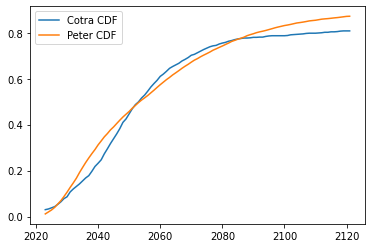

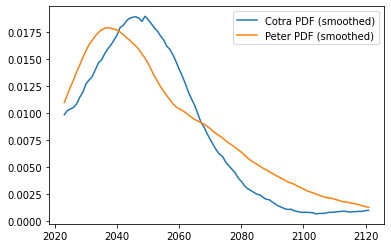

In [218]:
ajeya_cdf = [0.03 , 0.033, 0.038, 0.043, 0.053, 0.064, 0.078, 0.086, 0.107, 0.12 , 0.131, 0.142, 0.155, 0.168, 0.178,
             0.197, 0.218, 0.232, 0.247, 0.273, 0.295, 0.318, 0.339, 0.36 , 0.383, 0.41 , 0.425, 0.447, 0.469, 0.487,
             0.499, 0.516, 0.529, 0.546, 0.564, 0.579, 0.593, 0.61 , 0.62 , 0.632, 0.645, 0.653, 0.66 , 0.667, 0.677,
             0.684, 0.692, 0.702, 0.706, 0.713, 0.72 , 0.727, 0.733, 0.739, 0.743, 0.745, 0.751, 0.755, 0.758, 0.763,
             0.766, 0.77 , 0.773, 0.775, 0.777, 0.777, 0.778, 0.78 , 0.78 , 0.781, 0.781, 0.784, 0.786, 0.787, 0.787,
             0.787, 0.787, 0.787, 0.788, 0.791, 0.792, 0.793, 0.794, 0.795, 0.797, 0.798, 0.798, 0.798, 0.799, 0.8  ,
             0.802, 0.802, 0.804, 0.804, 0.805, 0.807, 0.808, 0.808, 0.808]
ajeya_pdf = np.append(np.array(ajeya_cdf[0]), np.diff(ajeya_cdf[:len(bins)]))
ajeya_pdf_smoothed = savitzky_golay(ajeya_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0115, 0.02  , 0.0286, 0.0397, 0.0542, 0.0688, 0.087 , 0.106 ,
       0.1267, 0.1462, 0.1668, 0.1911, 0.2134, 0.2351, 0.255 , 0.2739,
       0.2917, 0.3119, 0.3291, 0.3468, 0.3612, 0.3774, 0.3902, 0.405 ,
       0.4195, 0.4333, 0.4454, 0.4574, 0.4713, 0.4834, 0.496 , 0.507 ,
       0.5168, 0.527 , 0.5386, 0.55  , 0.5621, 0.5738, 0.5848, 0.5958,
       0.6055, 0.6163, 0.6256, 0.6351, 0.6451, 0.6542, 0.6626, 0.6719,
       0.6807, 0.6874, 0.6955, 0.7026, 0.7092, 0.7161, 0.724 , 0.7299,
       0.7363, 0.7422, 0.7488, 0.755 , 0.7621, 0.7669, 0.772 , 0.7761,
       0.7809, 0.7873, 0.7917, 0.7957, 0.8003, 0.8038, 0.8067, 0.81  ,
       0.8138, 0.8176, 0.8216, 0.825 , 0.8281, 0.8313, 0.8336, 0.8363,
       0.8394, 0.8425, 0.8443, 0.8464, 0.8488, 0.8515, 0.853 , 0.8544,
       0.8567, 0.8591, 0.8604, 0.8615, 0.863 , 0.8646, 0.8659, 0.8676,
       0.8694, 0.8712, 0.8718, 0.8732, 0.8743, 0.8761, 0.8772, 0.8788,
       0.8799, 0.8809, 0.8821, 0.8831, 0.8838, 0.885 , 0.8858, 0.8865,
       0.8868, 0.8875, 0.8881, 0.8887, 0.8894, 0.8903, 0.8905, 0.8914,
       0.8921, 0.893 , 0.8934, 0.8947, 0.8954, 0.896 , 0.8967, 0.897 ,
       0.8975, 0.8986, 0.8992, 0.8996, 0.9003, 0.9007, 0.9013, 0.9022,
       0.9026, 0.9031, 0.9039, 0.9046, 0.9047, 0.9049, 0.9054, 0.9059,
       0.9067, 0.9071, 0.9077, 0.9081, 0.9089, 0.9094, 0.91  , 0.9105,
       0.9108, 0.9116, 0.9123, 0.9123, 0.9124, 0.9129, 0.9131, 0.9138,
       0.9148, 0.9152, 0.9155, 0.916 , 0.9167, 0.9176, 0.918 , 0.9183,
       0.919 , 0.9194, 0.9197, 0.9201, 0.9207, 0.921 , 0.921 , 0.9211,
       0.9216, 0.9218, 0.922 , 0.9222, 0.9225, 0.9228, 0.9234, 0.9237,
       0.924 , 0.924 , 0.9241, 0.9243, 0.9248, 0.9251, 0.9251, 0.9259,
       0.926 , 0.9264, 0.9264, 0.9267, 0.9268, 0.9271, 0.9277]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], ajeya_cdf[:99], label='Cotra CDF')
plt.plot(bins[:99], peter_cdf[:99], label='Peter CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], ajeya_pdf_smoothed[:99], label='Cotra PDF (smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Peter PDF (smoothed)')
plt.legend()
plt.show()